## Data Analysis Rong360
##### **Summary**
[Users](#users): 
    - Average num of applications per user 1.7715
    - Rate of Approval for Users with PV activity (56,832 in users): 0.18324
    - Rate of Approval for Users with *NO* PV activity (81,889 users): 0.1623
    - Overall approval rate per custmer is 0.1712
[Banks](#banks):
    - 75% of banks have less than 4 products
    - 75% of banks have less than 5 locations (local banks) their avg application limit is 39.77 Yuan
    - approx 30% of banks have 0 approval rate, why?
[Products](#products):
    - Most popular product types are "6" and "100" we suspect these are individual loans and small business loans based on average loan quota max

### Chisq test
  [Contingency_Table](#chisq)
   - all but 3 columns reject the null hypothesis, meaning the probability of each column being independent is very small.
    
    

### Analysis Questions: Product Popularity and Customer Background Analysis
- The banks would like to know what types of loan products are more popular in the market. Please analyze the data
and provide insights on what types of products are most popular. 
Do their popularities evolve w.r.t. time or vary with applicants' locations?
- Describe the distribution of aggregate loan application counts during the total time period, either by the banks or by the products. What are the characteristics of banks or products which have low loan applications?
- Identify the banks or individual products whose loan application volumes are growing fastest. Are there banks or products which
lose attractiveness to the customers?
- Among the banks who sell similar loan products, any pattern on the loan popularities and approval rates? 
- Different loan products potentially can attract different types of customers. Please analyze the user profiles of 
different loan products. Please provide an in-depth analysis on how different types of product may attract different types of users.
Notice that the grouping of product types or user types are subject to your own research.

### Data Cleaning

In [3]:
import pandas as pd
import numpy as np

## this is a script for merging the tables into one

## load the tables
order_train = pd.read_table('Rong/order_train.txt')
print('size of order_train:', order_train.shape)
product_final = pd.read_table("Rong/product.final.txt")
print('size of product.final:', product_final.shape)
user_final = pd.read_table("Rong/user.final.txt")
print('size of user.final:', user_final.shape)
quality_final = pd.read_table("Rong/quality.final.txt")
print('size of quality.final:', quality_final.shape)

## the first three are easy to use a left-join with the training data
joined = order_train.merge(product_final, on='product_id', how='left')
print('size of order_train left-joined with product.final:', joined.shape)
joined = joined.merge(user_final, on='user_id', how='left', 
    suffixes=('_order', '_user'))
print('size when again left-joined with user.final:', joined.shape)

## quality_final has a lot of extra rows and duplicate rows
user_ids = joined['user_id'].unique()
quality_final = quality_final.loc[quality_final['user_id'].isin(user_ids)]

## the .pivot_table() method used later does not handle NaNs, so replace
## I do this column-by-column because if I try to use fillna() on the
## whole dataframe, my computer freezes
for col in quality_final.columns:
    quality_final[col] = quality_final[col].fillna('meowmeowmeow')

## the pivot_table() method returns the counts of the duplicates
counts = quality_final.pivot_table(index=quality_final.columns.tolist(), 
    aggfunc='size')

## drop the duplicates
quality_final = quality_final.drop_duplicates()

## sort the dataframe so that it matches the 'counts' Series
quality_final = quality_final.sort_values(by=quality_final.columns.tolist())

## create new column with the counts
quality_final['counts'] = counts.values

## remove the placeholder strings and replace with NaNs again
for col in quality_final.columns:
    quality_final[col] = quality_final[col].replace(to_replace='meowmeowmeow', 
        value=np.nan)
print('size of quality.final after processing:', quality_final.shape)

joined = joined.rename(columns={'term': 'application_term'})

totaldf = joined.merge(quality_final, on=['user_id', 'bank_id', 
    'application_term'], how='left', suffixes=('_product','_quality'))

print('size of total dataframe:', totaldf.shape)
totaldf.to_csv('../all_merged_data.csv', index=False)




/Users/itadmin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  import sys


size of order_train: (143152, 6)


/Users/itadmin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  if __name__ == '__main__':


size of product.final: (48433, 33)


/Users/itadmin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  # This is added back by InteractiveShellApp.init_path()


size of user.final: (238958, 12)


/Users/itadmin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  del sys.path[0]
/Users/itadmin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


size of quality.final: (1506097, 89)
size of order_train left-joined with product.final: (143152, 38)
size when again left-joined with user.final: (284819, 49)
size of quality.final after processing: (230244, 90)
size of total dataframe: (380865, 136)


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
%matplotlib inline

In [5]:
df = pd.read_csv('../all_merged_data.csv')
df.drop(['reapply_count','is_p2p'],axis=1,inplace=True)

In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_seq_items', None)
df.columns

Index(['user_id', 'product_id', 'date_order', 'application_term', 'limit',
       'result', 'city_id_product', 'bank_id', 'product_type_product',
       'guarantee_type_product', 'loan_term_min', 'loan_term_max',
       'loan_term_type', 'decision_cycle', 'loan_cycle', 'repayment_type',
       'loan_quota_min', 'loan_quota_max', 'interest_rate_type',
       'guarantee_required', 'standard_type_product', 'apply_num',
       'fangkuan_num', 'id', 'house_register', 'business_license',
       'legal_person', 'married', 'car', 'income', 'house', 'tax',
       'socialsecurity', 'bank', 'lifecost', 'early_repayment', 'penalty',
       'pv', 'pv_index_loan', 'pv_apply_total', 'pv_ask', 'pv_calculator',
       'order_count_loan', 'pv_daikuan', 'pv_credit', 'pv_search_daikuan',
       'pv_detail_daikuan', 'date_user', 'city_id_quality', 'application_type',
       'application_limit', 'op_type', 'col_type', 'user_loan_experience',
       'user_has_car', 'user_social_security', 'qid77', 'cash_rece

In [8]:
df.sample(20)

,user_id,product_id,date_order,application_term,limit,result,city_id_product,bank_id,product_type_product,guarantee_type_product,loan_term_min,loan_term_max,loan_term_type,decision_cycle,loan_cycle,repayment_type,loan_quota_min,loan_quota_max,interest_rate_type,guarantee_required,standard_type_product,apply_num,fangkuan_num,id,house_register,business_license,legal_person,married,car,income,house,tax,socialsecurity,bank,lifecost,early_repayment,penalty,pv,pv_index_loan,pv_apply_total,pv_ask,pv_calculator,order_count_loan,pv_daikuan,pv_credit,pv_search_daikuan,pv_detail_daikuan,date_user,city_id_quality,application_type,application_limit,op_type,col_type,user_loan_experience,user_has_car,user_social_security,qid77,cash_receipts,user_income_by_card,user_work_period,user_age,company_type,col_value,com_op_period,com_month_flow,qid123,qid122,qid135,qid139,qid93,qid57,cash_settlement,user_nationality,qid145,house_payment_records,car_value,qid137,qid133,qid140,qid78,loan_term,qid79,col_has_mortgage,qid146,loan_limit_n,op_type_n,col_type_n,user_loan_experience_n,user_has_car_n,user_social_security_n,qid77_n,cash_receipts_n,user_income_by_card_n,user_work_period_n,user_age_n,company_type_n,col_value_n,com_op_period_n,com_month_flow_n,qid123_n,qid122_n,qid135_n,qid139_n,qid93_n,qid57_n,user_nationality_n,qid145_n,house_payment_records_n,car_value_n,qid133_n,qid140_n,qid78_n,loan_description_n,loan_term_n,qid79_n,car_use_requirement_n,col_has_mortgage_n,qid146_n,product_type_quality,apply_from,platform,spam_score,mobile_verify,source,medium,is_paid,quality,mobile_source,mobile_medium,mobile_is_paid,mobile_quality,standard_type_quality,guarantee_type_quality,counts
329733,49d33c1f9cecbc51db60b4df29120c5c,7273b1f76b11c255147633185f76a9b9,1505,36,10.0,0,c81e728d9d4c2f636f067f89cc14862c,cfcd208495d565ef66e7dff9f98764da,100,2,12,48,1,0,2,0,50000,500000,0,0,2,70,13,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,53.0,0.0,6.0,1.0,0.0,1.0,53.0,0.0,21.0,13.0,400.0,c81e728d9d4c2f636f067f89cc14862c,9.0,10.0,4.0,0.0,0.0,0.0,1.0,1.0,0.0,9000.0,3.0,30.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,21.0,1.0,0.0,0.0,54.0,147.0,0.0,0.0,167.0,189.0,NaN,NaN,2.0,2.0,5.0
371943,c128593894ad5bd81af6cc67637d79f7,9104db5b849b60526b8a929cc045900d,1539,12,10.0,1,3c59dc048e8850243be8079a5c74d079,98ed99f6e48755fa5aeafc04675a7e67,6,2,6,48,1,2,3,1,9000,500000,2,0,1,2776,974,1,1,0,0,0,0,1,1,0,0,1,0,1.0,1.0,13.0,2.0,1.0,0.0,0.0,1.0,13.0,0.0,1.0,3.0,434.0,3c59dc048e8850243be8079a5c74d079,9.0,10.0,4.0,1.0,1.0,5.0,1.0,1.0,0.0,10000.0,48.0,31.0,8.0,120.0,NaN,NaN,3.0,2.0,1000.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,16.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,1.0,0.0,3.0,8.0,115.0,0.0,1.0,167.0,189.0,NaN,NaN,1.0,2.0,4.0
43330,694bc514cfe7fe6bbd04c209c73be95c,e0330da43b4d33f4ef9247ad260074f4,1100,12,3.0,0,6da37dd3139aa4d9aa55b8d237ec5d4a,69f268fb2ba1068615b3219c6e8f57e8,6,2,12,48,1,2,3,1,8000,300000,2,0,1,211,0,1,0,0,0,0,1,1,1,0,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6da37dd3139aa4d9aa55b8d237ec5d4a,2.0,3.0,4.0,0.0,1.0,0.0,NaN,NaN,0.0,6000.0,12.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,1.0,0.0,0.0,99.0,43.0,0.0,1.0,21.0,253.0,0.0,1.0,1.0,2.0,6.0
103293,b4316c1e29dd1025bb0bbd05901ec377,204da255aea2cd4a75ace6018fad6b4d,1220,12,4.0,0,c4ca4238a0b923820dcc509a6f75849b,63538fe6ef330c13a05a3ed7e599d5f7,6,2,1,36,1,1,2,1,10000,150000,2,0,1,6483,909,1,0,0,0,0,0,0,0,0,0,1,1,1.0,1.0,22.0,1.0,1.0,0.0,0.0,1.0,14.0,8.0,3.0,1.0,202.0,c4ca4238a0b923820dcc509a6f75849b,9.0,2.0,4.0,0.0,0.

### User Analysis
<a id='users'></a>

In [88]:
user_frequency = pd.DataFrame(quality_final.user_id.value_counts())

print(f"Average Number of Applications per User: {user_frequency.user_id.mean():.4f}")

Average Number of Applications per User: 1.7715


In [350]:
user_counts_by_city = quality_final.groupby('city_id').agg({'user_id':'count'}).reset_index().sort_values('user_id',ascending=False)


In [359]:
user_results = order_train[['result','user_id']]
user_results_merge = user_results.merge(user_final, on='user_id', how='inner')

In [360]:
uniqueusers_pvsum = user_results_merge.groupby('user_id').agg({'pv':'sum',\
                                           'pv_index_loan':'sum',\
                                           'pv_apply_total':'sum',\
                                           'pv_ask':'sum',\
                                           'pv_calculator':'sum',\
                                          'order_count_loan':'sum',\
                                          'pv_daikuan':'sum',\
                                          'pv_credit':'sum',\
                                          'pv_search_daikuan':'sum',\
                                          'pv_detail_daikuan':'sum',\
                                          'result':'mean'}).reset_index()

In [361]:
user_aprov = order_train.groupby('user_id')['result'].mean().reset_index().result.mean()
print(f"Overall approval rate by user: {user_aprov:.5f}")

Overall approval rate by user: 0.17123


In [362]:
#uniqueusers_pvsum = uniqueusers_pvsum.sort_values('result',ascending=False)
#uniqueusers_pvsum.loc[uniqueusers_pvsum['result'] == 1].describe()
#print(uniqueusers_pvsum.loc[uniqueusers_pvsum['result'] == 0].describe())
print(uniqueusers_pvsum.shape)
print(f"Rate of approval for users with pv activity: {uniqueusers_pvsum.result.mean():.5f}")

(56832, 12)
Rate of approval for users with pv activity: 0.18324


In [144]:
no_loan = uniqueusers_pvsum.loc[uniqueusers_pvsum['result'] == 0]
no_loan.describe()

,result,pv,pv_index_loan,pv_apply_total,pv_ask,pv_calculator,order_count_loan,pv_daikuan,pv_credit,pv_search_daikuan,pv_detail_daikuan
count,46873.0,46873.000000,46873.000000,46873.000000,46873.000000,46873.000000,46873.000000,46873.000000,46873.000000,46873.000000,46873.000000
mean,0.0,52.425746,1.290231,3.746272,1.410065,0.134790,1.886843,45.519873,6.271116,14.658844,9.953641
std,0.0,115.943000,3.686060,7.050423,6.546356,1.542801,2.765890,96.133071,26.136131,30.657569,31.527460
min,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,15.000000,0.000000,1.000000,0.000000,0.000000,1.000000,14.000000,0.000000,2.000000,2.000000
50%,0.0,28.000000,0.000000,2.000000,0.000000,0.000000,1.000000,25.000000,0.000000,8.000000,4.000000
75%,0.0,55.000000,1.000000,4.000000,1.000000,0.000000,2.000000,48.000000,3.000000,16.000000,10.000000
max,0.0,7220.000000,214.000000,632.000000,294.000000,122.000000,240.000000,6210.000000,1680.000000,1872.000000,2860.000000


In [176]:
unique_usersqual = quality_final.groupby('user_id').agg({'application_limit':'mean','quality':'mean'}).reset_index()
inner_qual = unique_usersqual.merge(user_results, on='user_id',how='inner')
inner_qual.describe()
# left_qual = unique_usersqual.merge(user_results, on='user_id',how='left')
# print(inner_qual.shape)
# left_qual.shape

,application_limit,quality,result
count,1.387570e+05,130264.000000,138757.000000
mean,7.045537e+01,0.815197,0.170031
std,8.792601e+03,0.513481,0.375661
min,0.000000e+00,0.000000,0.000000
25%,5.000000e+00,1.000000,0.000000
50%,5.000000e+00,1.000000,0.000000
75%,1.200000e+01,1.000000,0.000000
max,2.500005e+06,3.000000,1.000000


In [192]:
# users in quality/orders table and not in users
o_user_set = order_train.user_id.unique()
u_user_set = user_final.user_id.unique()
not_in_users = set(o_user_set) - set(u_user_set)

In [193]:
not_in_users = pd.DataFrame(not_in_users,columns=['user_id'])
not_in_users = not_in_users.merge(order_train,on='user_id', how='inner')

In [352]:
not_users_df = not_in_users.groupby('user_id').agg({'result':'mean'}).reset_index()
print(f"Rate of Approval for users with no PV activity: {not_users_df.result.mean():.4f}")
print(f"Number of users with no PV activity: {not_in_users.shape[0]}")

Rate of Approval for users with no PV activity: 0.1624
Number of users with no PV activity: 81889


## Banks Analysis
<a id = 'banks'> </a>

In [281]:
bank_appLimit = quality_final.groupby(['bank_id']).agg({'application_limit':"mean"}).reset_index()
bank_appLimit = bank_appLimit.sort_values('application_limit', ascending=False)

In [283]:
#banks in multiple cities
bank_city = product_final.groupby('bank_id').agg({'city_id':'count'}).reset_index()
bank_city = bank_city.merge(bank_appLimit, on='bank_id',how='inner')
bank_city.sample(10)

,bank_id,city_id,application_limit
36,05f971b5ec196b8c65b75d2ef8267331,1,91.818182
1488,f0b1d5879866f2c2eba77f39993d1184,2,9.933333
118,11d867796d85db8cad5280ac44cec7c1,1,68.200000
498,4c5bde74a8f110656874902f07378009,2,58.545455
763,7a53928fa4dd31e82c6ef826f341daec,3,25.647727
1275,cf67355a3333e6e143439161adc2d82e,5,5.876611
1047,a896b6cbbe199b67c0f76f6f0e4b55d5,1,10.418605
248,24a29a235c0678859695b10896513b3d,2,10.631579
249,24aef8cb3281a2422a59b51659f1ad2e,2,6.338129
87,0cf5d42e34cfeb8ae58bf0b5eca73375,5,9.615385


In [346]:
num_locations = bank_city.groupby('city_id').agg({'application_limit':'mean','bank_id':'count'}).reset_index()
num_locations = num_locations.sort_values('city_id')
num_locations = num_locations.rename({'city_id':'num_locations','bank_id':'num_banks','application_limit':'avg_appl_limit'},axis=1)
print(f"Percent of banks with 5 or less locations: {sum(num_locations[:5].num_banks)/sum(num_locations.num_banks):.4f}")
print(f"Average application limit for local banks: {num_locations[:5].avg_appl_limit.mean():.4f}")

Percent of banks with 5 or less locations: 0.7568
Average application limit for local banks: 39.7768


In [257]:
bank_products = product_final[['product_id','bank_id']]
bank_products_0 = bank_products.merge(order_train,on='product_id', how='inner')
bank_products = bank_products_0.groupby('bank_id')['product_id'].count().reset_index().sort_values('product_id',ascending=False)
bank_products = bank_products.rename({'product_id':'num_products'},axis=1)

In [313]:
bank_products.num_products.value_counts().describe()
# this is the amunt of banks with the same number of products
# 75% of them have less than 4 products

count    268.000000
mean       5.955224
std       15.011289
min        1.000000
25%        1.000000
50%        2.000000
75%        3.250000
max      139.000000
Name: num_products, dtype: float64

In [272]:
bank_aprov_rate = bank_products_0.groupby('bank_id')['result'].mean().reset_index()


In [278]:
location_approval_rate = bank_aprov_rate.merge(bank_city, on='bank_id', how='inner').groupby('city_id')\
                            .agg({'result':'mean',\
                                    'application_limit':'mean'}).reset_index().rename({'city_id':'num_cities'},axis=1)

In [314]:
location_approval_rate.sort_values('result')

,num_cities,result,application_limit
14,15,0.022321,147.307692
18,26,0.065693,73.972743
1,2,0.073151,68.683121
0,1,0.074992,42.696005
2,3,0.076164,36.210915
19,39139,0.086299,153.281511
5,6,0.086913,24.271251
15,16,0.088436,85.619938
3,4,0.092433,28.710724
7,8,0.106818,21.500579


In [328]:
# bank_aprov_rate.sort_values('result')


In [331]:
bank_aprov_rate.result.value_counts()
low_approval_banks = pd.DataFrame(bank_aprov_rate.loc[bank_aprov_rate['result']<=0.01]['bank_id'])
low_approval_0 = low_approval_banks.merge(quality_final,on='bank_id', how='inner')
low_approval = low_approval_0.merge(product_final,on='bank_id',how='inner')

In [338]:
# for col in low_approval.columns:
#     print("-"*50)
#     print(low_approval[col].isnull().value_counts())

--------------------------------------------------
False    103176
Name: bank_id, dtype: int64
--------------------------------------------------
False    103176
Name: user_id, dtype: int64
--------------------------------------------------
False    103176
Name: city_id_x, dtype: int64
--------------------------------------------------
False    103176
Name: application_type, dtype: int64
--------------------------------------------------
False    103176
Name: application_term, dtype: int64
--------------------------------------------------
False    103176
Name: application_limit, dtype: int64
--------------------------------------------------
False    73481
True     29695
Name: op_type, dtype: int64
--------------------------------------------------
False    56452
True     46724
Name: col_type, dtype: int64
--------------------------------------------------
False    52698
True     50478
Name: user_loan_experience, dtype: int64
--------------------------------------------------
True    

### Products Analysis
<a id='products'></a>

The banks would like to know what types of loan products are more popular in the market. 
Please analyze the data and provide insights on what types of products are most popular. 
Do their popularities evolve w.r.t. time or vary with applicants' locations?

## Looking at most popular product ID's and product types based on number of applications

In [9]:
df['counts'] = df['counts'].fillna(1)
product_ids_grouped = df.groupby('product_id').agg({'counts':'sum'})
product_type_products_grouped = df.groupby('product_type_product').agg({'counts':'sum'})
product_type_quality_grouped = df.groupby('product_type_quality').agg({'counts':'sum'})

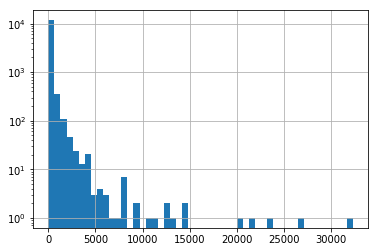

In [10]:
product_ids_grouped['counts'].hist(bins=50, log=True)

The histogram above shows the counts for different product IDs. It's clearly skewed, with most having less than 5000 application counts, while very few have more than 10000.

## Product Types

Below we look at the product types associated with the "product" table, and the product type associated with the "quality" table. The most common are "100" and "6" for the product, and "1" and "2" for the quality. The least popular are "101" and "102", and "102", respsectively.

In [11]:
product_type_products_grouped['counts'].sort_values()

product_type_product
101        256.0
102        503.0
4         4128.0
2         7920.0
3        16081.0
5        57701.0
1       176893.0
100     798199.0
6      1017683.0
Name: counts, dtype: float64

In [12]:
product_type_quality_grouped['counts'].sort_values()

product_type_quality
102.0         36.0
0.0         6068.0
5.0         6316.0
100.0      11874.0
3.0        17437.0
6.0        39765.0
4.0        49148.0
1.0       248457.0
2.0      1686479.0
Name: counts, dtype: float64

Below, try to see if there's an association between the product and quality product types, but there isn't much

In [13]:
print(df.loc[df['product_type_product']==6]['product_type_quality'].value_counts())
print(df.loc[df['product_type_product']==6]['product_id'].nunique())

2.0    164970
1.0     14106
6.0      3690
4.0      3365
3.0       288
5.0        12
Name: product_type_quality, dtype: int64
2651


In [14]:
print(df.loc[df['product_type_product']==100]['product_type_quality'].value_counts())
print(df.loc[df['product_type_product']==100]['product_id'].nunique())

2.0      104113
1.0       15472
4.0        4818
6.0        3530
3.0        1846
100.0      1794
5.0         969
0.0         112
Name: product_type_quality, dtype: int64
7971


100    15472
6      14106
5       9448
1       4720
3        744
4        437
102        6
101        3
Name: product_type_product, dtype: int64
2104


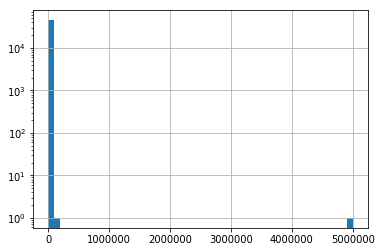

In [15]:
print(df.loc[df['product_type_quality']==1]['product_type_product'].value_counts())
print(df.loc[df['product_type_quality']==1]['product_id'].nunique())
df.loc[df['product_type_quality']==1].limit.hist(bins=50,log=True)

In [16]:
print(df.loc[df['product_type_quality']==2]['product_type_product'].value_counts())
print(df.loc[df['product_type_quality']==2]['product_id'].nunique())

6      164970
100    104113
1       26733
2        1514
3        1034
4         267
102        66
101        32
Name: product_type_product, dtype: int64
9305


## popular product IDs
Here we see that the most popular products, by ID, are all of product type "6" for the "product", and are either 2,4,or 6 of the "quality" product type

6    37986
Name: product_type_product, dtype: int64
2.0    37546
6.0      431
4.0        9
Name: product_type_quality, dtype: int64
e07bceab69529b0f0b43625953fbf2a0    5980
02180771a9b609a26dcea07f272e141f    4673
dc20d1211f3e7a99d775b26052e0163e    4334
2723d092b63885e0d7c260cc007e8b9d    3784
70efdf2ec9b086079795c442636b55fb    3714
8cbd005a556ccd4211ce43f309bc0eac    2534
42d6c7d61481d1c21bd1635f59edae05    2459
204da255aea2cd4a75ace6018fad6b4d    2358
2bc8ae25856bc2a6a1333d1331a3b7a6    2183
1f0e3dad99908345f7439f8ffabdffc4    2120
bd686fd640be98efaae0091fa301e613    2015
202cb962ac59075b964b07152d234b70    1832
Name: product_id, dtype: int64


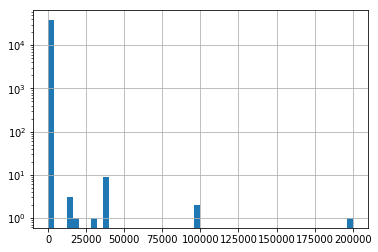

In [17]:
print(df.loc[df['product_id'].isin(product_ids_grouped.\
        loc[product_ids_grouped['counts'] > 10000].index)]['product_type_product'].\
        value_counts())
print(df.loc[df['product_id'].isin(product_ids_grouped.\
        loc[product_ids_grouped['counts'] > 10000].index)]['product_type_quality'].\
        value_counts())
print(df.loc[df['product_id'].isin(product_ids_grouped.\
        loc[product_ids_grouped['counts'] > 10000].index)]['product_id'].\
        value_counts())
df.loc[df['product_id'].isin(product_ids_grouped.\
        loc[product_ids_grouped['counts'] > 10000].index)]['limit'].\
        hist(bins=50, log=True)

## unpopular product IDs
These values show no distinct pattern

100    3012
6       629
1       277
5       115
3        29
102      12
4         7
101       4
2         1
Name: product_type_product, dtype: int64
2.0      1693
1.0       351
4.0       184
3.0        37
100.0      35
6.0        27
0.0         7
5.0         7
Name: product_type_quality, dtype: int64


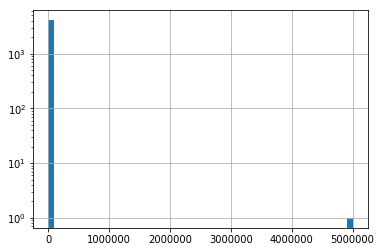

In [18]:
print(df.loc[df['product_id'].isin(product_ids_grouped.\
        loc[product_ids_grouped['counts'] < 10].index)]['product_type_product'].\
        value_counts())
print(df.loc[df['product_id'].isin(product_ids_grouped.\
        loc[product_ids_grouped['counts'] < 10].index)]['product_type_quality'].\
        value_counts())
df.loc[df['product_id'].isin(product_ids_grouped.\
        loc[product_ids_grouped['counts'] < 10].index)]['limit'].hist(bins=50, log=True)

## same city?

In [19]:
df['same_city'] = (df['city_id_product'] == df['city_id_quality'])*1

In [20]:
df.loc[df['same_city']==1].result.mean()

0.14982516496531498

In [21]:
df.loc[df['same_city']==0].result.mean()

0.11849876166888931

In [22]:
popular_products = df.loc[df['product_id'].isin(product_ids_grouped.\
        loc[product_ids_grouped['counts'] > 10000].index)]

In [23]:
unpopular_products = df.loc[~df['product_id'].isin(product_ids_grouped.\
        loc[product_ids_grouped['counts'] < 10000].index)]

In [24]:
nonobject_columns = df.columns[df.dtypes != object]

In [25]:
object_columns = df.columns[df.dtypes == object]
object_columns

Index(['user_id', 'product_id', 'city_id_product', 'bank_id',
       'city_id_quality'],
      dtype='object')

In [26]:
smaller_categoricals_columns = []
numerical_columns = []
for colname in nonobject_columns:
    if df[colname].nunique() <= 5:
        smaller_categoricals_columns.append(colname)
    else:
        numerical_columns.append(colname)

In [27]:
len(smaller_categoricals_columns)

70

In [28]:
len(numerical_columns)

60

/Users/itadmin/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/itadmin/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


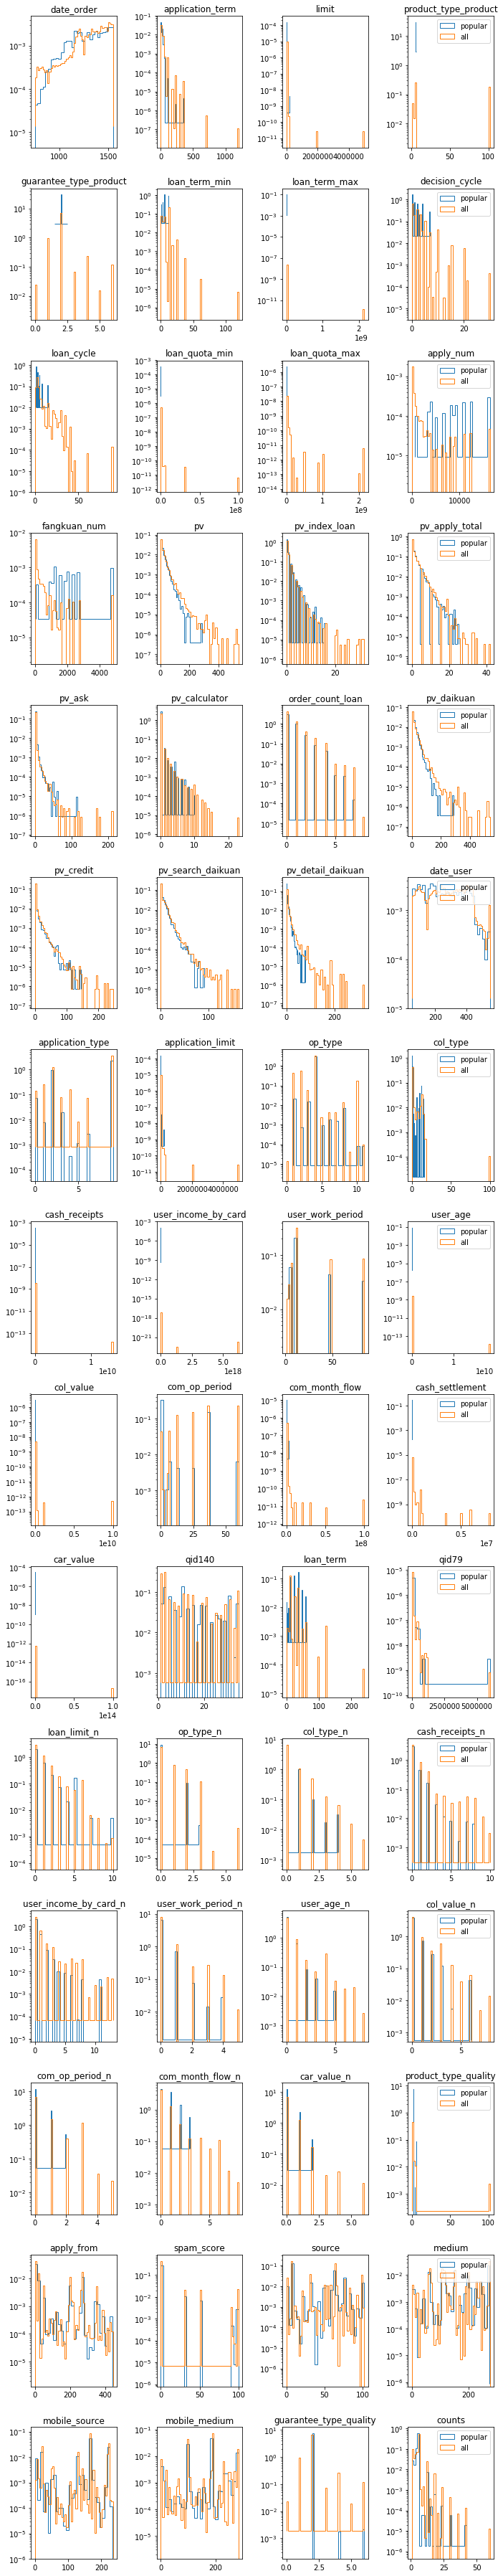

In [29]:
plt.rcParams["figure.figsize"] = (10,50)
for i, colname in enumerate(numerical_columns):
    plt.subplot(15,4,i+1)
    plt.title(colname)
  #  if unpopular_products[colname].notna().sum() != 0:
   #     plt.hist(unpopular_products[colname], bins=30, histtype='step',log=1,  density=1, label="unpopular")
    if popular_products[colname].notna().sum() != 0:
        plt.hist(popular_products[colname],bins=30, histtype='step', log=1, density=1,label="popular")
    plt.hist(df[colname],bins=50, histtype='step', log=1, density=True, label="all")
    if (i+1)%4==0: plt.legend()
plt.tight_layout()

In [30]:
popular_dict = {}
for colname in smaller_categoricals_columns:
    print(colname)
    contingency_table = pd.concat([popular_products[colname].value_counts().rename("popular"), 
                     df[colname].value_counts().rename("all")], axis=1).fillna(0)
    print(pd.concat([popular_products[colname].value_counts(normalize=1).rename("popular"), 
                     unpopular_products[colname].value_counts(normalize=True).rename("unpopular"),
                    df[colname].value_counts(normalize=True).rename("all")], axis=1))
    popular_dict[colname] = chi2_contingency(contingency_table)[1]

#popular_contingencies = pd.Series(popular_contingencies)

result
    popular  unpopular       all
0  0.679303   0.679303  0.852334
1  0.320697   0.320697  0.147666
loan_term_type
    popular  unpopular      all
1  0.607434   0.607434  0.66109
2  0.392566   0.392566  0.33891
repayment_type
   popular  unpopular       all
0      NaN        NaN  0.360734
1      1.0        1.0  0.600554
2      NaN        NaN  0.024116
3      NaN        NaN  0.014596
interest_rate_type
    popular  unpopular       all
0  0.784342   0.784342  0.915831
1       NaN        NaN  0.000252
2  0.215658   0.215658  0.083917
guarantee_required
   popular  unpopular       all
0      1.0        1.0  0.994615
1      NaN        NaN  0.005385
standard_type_product
   popular  unpopular       all
1      1.0        1.0  0.639332
2      NaN        NaN  0.360668
id
    popular  unpopular       all
1  0.946954   0.946954  0.631171
0  0.053046   0.053046  0.368829
house_register
   popular  unpopular      all
0  0.60546    0.60546  0.85325
1  0.39454    0.39454  0.14675
business_licen

      popular  unpopular       all
0.0  0.335729   0.335729  0.282619
1.0  0.053967   0.053967  0.028806
2.0  0.312957   0.312957  0.308736
3.0  0.297346   0.297346  0.379840
is_paid
     popular  unpopular      all
0.0  0.96479    0.96479  0.95892
1.0  0.03521    0.03521  0.04108
quality
      popular  unpopular       all
1.0  0.783831   0.783831  0.716055
0.0  0.188845   0.188845  0.235462
3.0  0.017879   0.017879  0.034410
2.0  0.009445   0.009445  0.014073
mobile_is_paid
      popular  unpopular       all
0.0  0.999954   0.999954  0.999986
1.0  0.000046   0.000046  0.000014
mobile_quality
      popular  unpopular       all
1.0  0.930745   0.930745  0.898068
0.0  0.067519   0.067519  0.100458
2.0  0.001690   0.001690  0.001375
3.0  0.000046   0.000046  0.000100
standard_type_quality
     popular  unpopular       all
1.0      1.0        1.0  0.638292
2.0      NaN        NaN  0.361708
same_city
    popular  unpopular       all
1  0.995762   0.995762  0.931091
0  0.004238   0.004238  0

### Contingency tables
<a id='chisq'></a>

In [31]:
contingencies = pd.DataFrame(pd.Series(popular_dict), columns=["popular/unpopular"])

In [32]:
contingencies

,popular/unpopular
result,0.000000e+00
loan_term_type,8.186984e-98
repayment_type,0.000000e+00
interest_rate_type,0.000000e+00
guarantee_required,2.219393e-46
standard_type_product,0.000000e+00
id,0.000000e+00
house_register,0.000000e+00
business_license,0.000000e+00
legal_person,1.043482e-109


## Accepted Vs Rejected 

In [33]:
accepted = df.loc[df['result']==1]
rejected = df.loc[df['result']==0]

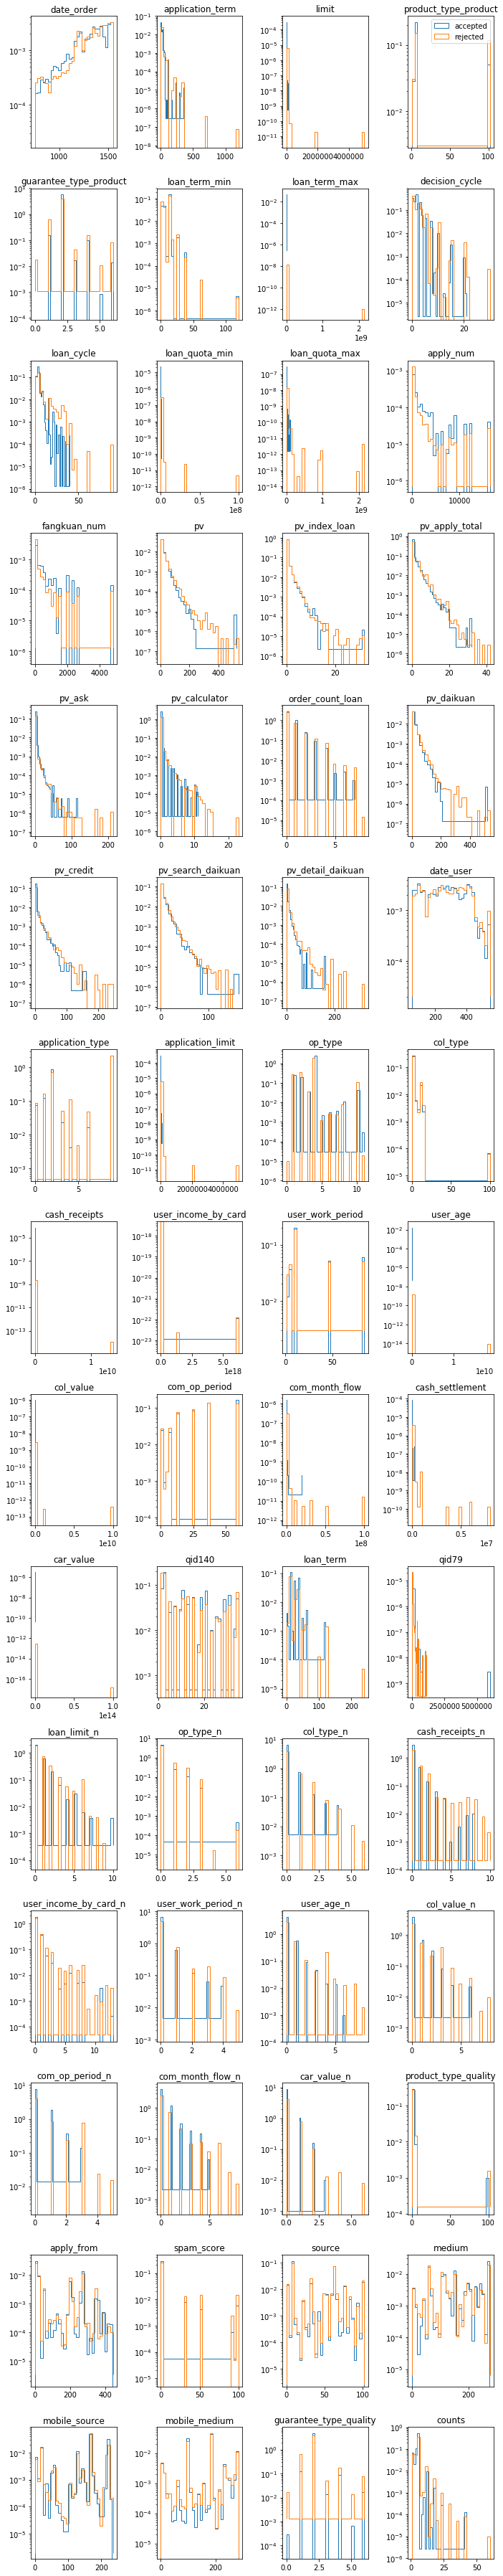

In [34]:
plt.rcParams["figure.figsize"] = (10,50)
for i, colname in enumerate(numerical_columns):
    plt.subplot(15,4,i+1)
    plt.title(colname)
    if accepted[colname].notna().sum() != 0:
        plt.hist(accepted[colname], bins=30, histtype='step', log=5, density=True, label="accepted")
    if rejected[colname].notna().sum() != 0:
        plt.hist(rejected[colname],bins=30, histtype='step', log=5, density=True, label="rejected")
   # plt.hist(df[colname],bins=50, histtype='step', density=True,label="all")
    if i==3: plt.legend()
plt.tight_layout()

In [35]:
result_dict = {}
for colname in smaller_categoricals_columns:
    print(colname)
    print(pd.concat([accepted[colname].value_counts(normalize=1).rename("accepted"), 
            rejected[colname].value_counts(normalize=True).rename("rejected")], axis=1))
    contingency_table = pd.concat([accepted[colname].value_counts().rename("accepted"), 
                     rejected[colname].value_counts().rename("rejected")], axis=1).fillna(0)
    result_dict[colname] = chi2_contingency(contingency_table)[1]

result
   accepted  rejected
0       NaN       1.0
1       1.0       NaN
loan_term_type
   accepted  rejected
1  0.478725  0.692684
2  0.521275  0.307316
repayment_type
   accepted  rejected
1  0.812148  0.563895
0  0.169414  0.393880
2  0.014064  0.025858
3  0.004374  0.016367
interest_rate_type
   accepted  rejected
0  0.873117  0.923231
2  0.126847  0.076479
1  0.000036  0.000290
guarantee_required
   accepted  rejected
0  0.998862  0.993879
1  0.001138  0.006121
standard_type_product
   accepted  rejected
1  0.830657  0.606184
2  0.169343  0.393816
id
   accepted  rejected
1  0.820505  0.598369
0  0.179495  0.401631
house_register
   accepted  rejected
0  0.872477  0.849919
1  0.127523  0.150081
business_license
   accepted  rejected
0   0.88656  0.878684
1   0.11344  0.121316
legal_person
   accepted  rejected
0  0.992141  0.986212
1  0.007859  0.013788
married
   accepted  rejected
0  0.897512  0.847125
1  0.102488  0.152875
car
   accepted  rejected
0  0.847051  0.872431
1  0.15

In [36]:
contingencies = pd.concat([contingencies, pd.Series(result_dict, name='accept/reject')], axis=1)

In [37]:
contingencies

,popular/unpopular,accept/reject
result,0.000000e+00,0.000000e+00
loan_term_type,8.186984e-98,0.000000e+00
repayment_type,0.000000e+00,0.000000e+00
interest_rate_type,0.000000e+00,0.000000e+00
guarantee_required,2.219393e-46,4.722700e-50
standard_type_product,0.000000e+00,0.000000e+00
id,0.000000e+00,0.000000e+00
house_register,0.000000e+00,3.085867e-44
business_license,0.000000e+00,1.183050e-07
legal_person,1.043482e-109,1.695597e-30


In [38]:
result_dict = {}
for colname in smaller_categoricals_columns:
    contingency_table = pd.concat([accepted[colname].value_counts().rename("accepted"), 
                     popular_products[colname].value_counts().rename("rejected")], axis=1).fillna(0)
    result_dict[colname] = chi2_contingency(contingency_table)[1]

In [39]:
contingencies = pd.concat([contingencies, pd.Series(result_dict, name="popular/accept")], 
                          axis=1)

In [40]:
contingencies = contingencies.round(decimals=6)

In [41]:
(contingencies > 0.05).T

,result,loan_term_type,repayment_type,interest_rate_type,guarantee_required,standard_type_product,id,house_register,business_license,legal_person,married,car,income,house,tax,socialsecurity,bank,lifecost,early_repayment,penalty,user_loan_experience,user_has_car,user_social_security,qid77,company_type,qid123,qid122,qid135,qid139,qid93,qid57,user_nationality,qid145,house_payment_records,qid137,qid133,qid78,col_has_mortgage,qid146,user_loan_experience_n,user_has_car_n,user_social_security_n,qid77_n,company_type_n,qid123_n,qid122_n,qid135_n,qid139_n,qid93_n,qid57_n,user_nationality_n,qid145_n,house_payment_records_n,qid133_n,qid140_n,qid78_n,loan_description_n,loan_term_n,qid79_n,car_use_requirement_n,col_has_mortgage_n,qid146_n,platform,mobile_verify,is_paid,quality,mobile_is_paid,mobile_quality,standard_type_quality,same_city
popular/unpopular,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False
accept/reject,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
popular/accept,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False


In [42]:
contingencies.to_csv('contingency_pvals.csv', index=True)

In [43]:
contingencies.index[(contingencies.T <= 0.05).all()]

Index(['result', 'loan_term_type', 'repayment_type', 'interest_rate_type',
       'guarantee_required', 'standard_type_product', 'id', 'house_register',
       'business_license', 'legal_person', 'married', 'car', 'income', 'house',
       'tax', 'bank', 'lifecost', 'early_repayment', 'penalty',
       'user_loan_experience', 'user_has_car', 'user_social_security', 'qid77',
       'company_type', 'qid123', 'qid122', 'qid135', 'qid139', 'qid93',
       'qid57', 'user_nationality', 'qid145', 'house_payment_records',
       'qid137', 'user_loan_experience_n', 'user_has_car_n',
       'user_social_security_n', 'qid77_n', 'company_type_n', 'qid123_n',
       'qid122_n', 'qid135_n', 'qid139_n', 'qid93_n', 'qid57_n',
       'user_nationality_n', 'qid145_n', 'house_payment_records_n', 'qid133_n',
       'qid140_n', 'qid78_n', 'loan_term_n', 'qid79_n', 'col_has_mortgage_n',
       'qid146_n', 'platform', 'mobile_verify', 'is_paid', 'quality',
       'mobile_quality', 'standard_type_quality', 's

In [45]:
contingencies.sort_values('accept/reject')

,popular/unpopular,accept/reject,popular/accept
result,0.000000,0.000000,0.000000
standard_type_quality,0.000000,0.000000,0.000000
qid78,0.000000,0.000000,0.122113
col_has_mortgage,0.000000,0.000000,0.309494
user_loan_experience_n,0.000000,0.000000,0.000000
user_has_car_n,0.000000,0.000000,0.000000
user_social_security_n,0.000000,0.000000,0.000000
qid77_n,0.000000,0.000000,0.000000
company_type_n,0.000000,0.000000,0.000000
qid123_n,0.000000,0.000000,0.016922


In [47]:
contingencies = contingencies.drop(['qid133','socialsecurity','mobile_is_paid'],axis=0)